In [167]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np
import matplotlib.pyplot as plt
import re

In [248]:
from src.exploration_utils import gpt_layer_analysis, collect_params, plot_weight_distro

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2Model.from_pretrained('gpt2-xl')

Downloading: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.66MB/s]
Downloading: 100%|██████████| 456k/456k [00:00<00:00, 2.47MB/s]
Downloading: 100%|██████████| 689/689 [00:00<00:00, 118kB/s]
Downloading: 100%|██████████| 6.43G/6.43G [12:14<00:00, 8.75MB/s]


In [5]:
model.named_parameters

<bound method Module.named_parameters of GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (

In [6]:
params = model.state_dict() 

In [9]:
len(params.keys())

676

### GPT2-XL Architecture
Each of the 48 layers of GPT-XL consists of:
<br>
#### Layer Norm 1
'h.0.ln_1.weight' # [1600]
<br>
'h.0.ln_1.bias # [1600]'
<br>

#### Self-Attention
'h.0.attn.bias' # [1, 1, 1024, 1024]
<br>
'h.0.attn.masked_bias' # []
<br>
'h.0.attn.c_attn.weight' # [1600, 4800]
<br>
'h.0.attn.c_attn.bias' # [4800]
<br>
'h.0.attn.c_proj.weight' # [1600, 1600]
<br>
'h.0.attn.c_proj.bias' # [1600]
<br>

#### Layer Norm 2
'h.0.ln_2.weight' # [1600]
<br>
'h.0.ln_2.bias' # [1600]
<br>

#### Feed Forward
'h.0.mlp.c_fc.weight' # [1600, 6400]
<br>
'h.0.mlp.c_fc.bias' # [6400]
<br>
'h.0.mlp.c_proj.weight' [6400, 1600]
<br>
'h.0.mlp.c_proj.bias' # [1600]


In [246]:
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

Total Parameters: 1557611200


In [247]:
bins_labs = ["0 to 1E-06", "1E-06 to 1E-05", "1E-05 to 1E-04", "1E-04 to 1E-03",
             "1E-03 to 1E-02", "1E-02 to 1E-01", "1E-01 to 1", "1 to 10"]

(array([  524568,     6685,    68245,   679179,  6646613, 23000101,
          339050,   524935]),
 array([1.65013620e-02, 2.10290381e-04, 2.14678640e-03, 2.13649680e-02,
        2.09082839e-01, 7.23515334e-01, 1.06655129e-02, 1.65129067e-02]))

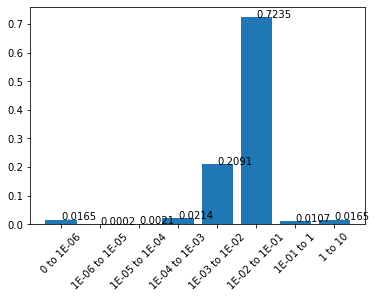

In [210]:
gpt_layer_analysis(1, params)

In [240]:
non_embed_param_names = list(params.keys())
non_embed_param_names.remove('wpe.weight')
non_embed_param_names.remove('wte.weight')
all_layers = collect_params(params, non_embed_param_names)

h.0.ln_1.weight
h.0.ln_1.bias
h.0.attn.bias
h.0.attn.masked_bias
h.0.attn.c_attn.weight
h.0.attn.c_attn.bias
h.0.attn.c_proj.weight
h.0.attn.c_proj.bias
h.0.ln_2.weight
h.0.ln_2.bias
h.0.mlp.c_fc.weight
h.0.mlp.c_fc.bias
h.0.mlp.c_proj.weight
h.0.mlp.c_proj.bias
h.1.ln_1.weight
h.1.ln_1.bias
h.1.attn.bias
h.1.attn.masked_bias
h.1.attn.c_attn.weight
h.1.attn.c_attn.bias
h.1.attn.c_proj.weight
h.1.attn.c_proj.bias
h.1.ln_2.weight
h.1.ln_2.bias
h.1.mlp.c_fc.weight
h.1.mlp.c_fc.bias
h.1.mlp.c_proj.weight
h.1.mlp.c_proj.bias
h.2.ln_1.weight
h.2.ln_1.bias
h.2.attn.bias
h.2.attn.masked_bias
h.2.attn.c_attn.weight
h.2.attn.c_attn.bias
h.2.attn.c_proj.weight
h.2.attn.c_proj.bias
h.2.ln_2.weight
h.2.ln_2.bias
h.2.mlp.c_fc.weight
h.2.mlp.c_fc.bias
h.2.mlp.c_proj.weight
h.2.mlp.c_proj.bias
h.3.ln_1.weight
h.3.ln_1.bias
h.3.attn.bias
h.3.attn.masked_bias
h.3.attn.c_attn.weight
h.3.attn.c_attn.bias
h.3.attn.c_proj.weight
h.3.attn.c_proj.bias
h.3.ln_2.weight
h.3.ln_2.bias
h.3.mlp.c_fc.weight
h.3.mlp.

h.30.attn.bias
h.30.attn.masked_bias
h.30.attn.c_attn.weight
h.30.attn.c_attn.bias
h.30.attn.c_proj.weight
h.30.attn.c_proj.bias
h.30.ln_2.weight
h.30.ln_2.bias
h.30.mlp.c_fc.weight
h.30.mlp.c_fc.bias
h.30.mlp.c_proj.weight
h.30.mlp.c_proj.bias
h.31.ln_1.weight
h.31.ln_1.bias
h.31.attn.bias
h.31.attn.masked_bias
h.31.attn.c_attn.weight
h.31.attn.c_attn.bias
h.31.attn.c_proj.weight
h.31.attn.c_proj.bias
h.31.ln_2.weight
h.31.ln_2.bias
h.31.mlp.c_fc.weight
h.31.mlp.c_fc.bias
h.31.mlp.c_proj.weight
h.31.mlp.c_proj.bias
h.32.ln_1.weight
h.32.ln_1.bias
h.32.attn.bias
h.32.attn.masked_bias
h.32.attn.c_attn.weight
h.32.attn.c_attn.bias
h.32.attn.c_proj.weight
h.32.attn.c_proj.bias
h.32.ln_2.weight
h.32.ln_2.bias
h.32.mlp.c_fc.weight
h.32.mlp.c_fc.bias
h.32.mlp.c_proj.weight
h.32.mlp.c_proj.bias
h.33.ln_1.weight
h.33.ln_1.bias
h.33.attn.bias
h.33.attn.masked_bias
h.33.attn.c_attn.weight
h.33.attn.c_attn.bias
h.33.attn.c_proj.weight
h.33.attn.c_proj.bias
h.33.ln_2.weight
h.33.ln_2.bias
h.33.mlp

In [237]:
len(non_embed_param_names)

674

In [241]:
all_layers.shape

torch.Size([1525893248])

In [242]:
cnts_all, pcts_all = weight_size_distro(all_layers)

In [243]:
pcts_all

array([1.64967215e-02, 1.82185091e-04, 1.81961484e-03, 1.81910425e-02,
       1.79178803e-01, 7.51039324e-01, 1.65812366e-02, 1.65110731e-02])

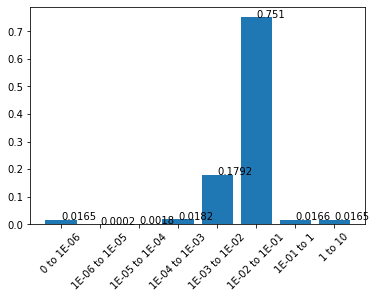

In [244]:
plot_weight_distro(bins_labs, pcts_all)

The plot above shows that 75% of the 1.5 billion non-embedding parameters in gpt-xl have an absolute value between .001 and .01. A further 18% of parameters are between .0001 and .001. The remaining ~7% of weights are equally distributed between being larger than .001 and smaller than .0001